# 1. 데이터 로드 및 전처리

## 1.1 필요한 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')
# 데이터가 저장된 기본 경로
base_path = 'datasets/test_dataset'


## 1.2 Parquet 파일 불러오기 및 전처리

In [2]:
def load_parquet_data():
    acc_files = [
        'ch2024_test__m_acc_part_5.parquet.gzip',
        'ch2024_test__m_acc_part_6.parquet.gzip',
        'ch2024_test__m_acc_part_7.parquet.gzip',
        'ch2024_test__m_acc_part_8.parquet.gzip'
    ]
    
    acc_data = pd.concat([pd.read_parquet(f'{base_path}/{file}') for file in tqdm(acc_files)])
    activity_data = pd.read_parquet(f'{base_path}/ch2024_test_m_activity.parquet.gzip')
    hr_data = pd.read_parquet(f'{base_path}/ch2024_test_w_heart_rate.parquet.gzip')
    
    return acc_data, activity_data, hr_data

# 데이터 불러오기
acc_data, activity_data, hr_data = load_parquet_data()

acc_data = acc_data.reset_index(drop=True)

activity_data = activity_data.reset_index(drop=True)
hr_data = hr_data.reset_index(drop=True)

acc_data['date'] = acc_data['timestamp'].dt.date

activity_data['date'] = activity_data['timestamp'].dt.date
hr_data['date'] = hr_data['timestamp'].dt.date

hr_data['heart_rate'].replace(0, np.nan, inplace=True)

  0%|          | 0/4 [00:00<?, ?it/s]

acc load 완료
acc reset_index 완료
acc date컬럼 추가 완료


In [ ]:
def save_grouped_data(df, file_prefix):
    for (subject_id, date), group in df.groupby(['subject_id', 'date']):
        directory = f'group_dataset/test/{file_prefix}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        file_path = f'{directory}/user{subject_id}_{date}.parquet'
        group.to_parquet(file_path)

# Group and save the data
save_grouped_data(acc_data, 'acc')
save_grouped_data(activity_data, 'activity')
save_grouped_data(hr_data, 'hr')

# 2. 데이터 병합

In [4]:
def make_timestamps_unique(df, timestamp_col='timestamp'):
    # 'timestamp' 컬럼을 기준으로 정렬
    df = df.sort_values(by=[timestamp_col])
    # 각 'timestamp'가 중복된 횟수를 세어 나노초 단위로 증가시킴
    df[timestamp_col] = df[timestamp_col] + pd.to_timedelta(df.groupby(timestamp_col).cumcount(), unit='ns')
    return df


In [5]:
import pandas as pd
from datetime import datetime, timedelta

def make_timestamps_unique(df, timestamp_col='timestamp'):
    df = df.sort_values(by=[timestamp_col])
    df[timestamp_col] = df[timestamp_col] + pd.to_timedelta(df.groupby(timestamp_col).cumcount(), unit='ns')
    return df

def merge_data_for_group(user, date):
    # 데이터 로드
    acc_group = pd.read_parquet(f'group_dataset/test/acc/user{user}_{date}.parquet').reset_index(drop=True)
    activity_group = pd.read_parquet(f'group_dataset/test/activity/user{user}_{date}.parquet').reset_index(drop=True)
    activity_group['m_activity'] = activity_group['m_activity'].astype('int')
    hr_group = pd.read_parquet(f'group_dataset/test/hr/user{user}_{date}.parquet').reset_index(drop=True)

    # 'timestamp'를 고유하게 만듦
    acc_group = make_timestamps_unique(acc_group)
    activity_group = make_timestamps_unique(activity_group)
    hr_group = make_timestamps_unique(hr_group)

    # 'timestamp'를 인덱스로 설정하고 'subject_id'와 'date' 컬럼 제거
    mAcc_data = acc_group.set_index('timestamp').drop(columns=['subject_id', 'date']).resample('S').nearest()
    activity_data = activity_group.set_index('timestamp').drop(columns=['subject_id', 'date']).resample('S').nearest()
    e4Hr_data = hr_group.set_index('timestamp').drop(columns=['subject_id', 'date']).resample('S').nearest()

    # 하루 86400초의 타임스탬프 생성
    start_time = datetime.strptime(date, '%Y-%m-%d')
    end_time = start_time + timedelta(days=1)
    all_timestamps = pd.date_range(start=start_time, end=end_time, freq='S', closed='left')

    merged_data = pd.DataFrame(index=all_timestamps)
    merged_data.index.name = 'timestamp'

    # 데이터 병합
    if not mAcc_data.empty:
        merged_data = merged_data.join(mAcc_data, how='left')
    if not e4Hr_data.empty:
        merged_data = merged_data.join(e4Hr_data, how='left')
    if not activity_data.empty:
        merged_data = merged_data.join(activity_data, how='left')
        
    # 필요한 컬럼만 유지하고 NaN 값으로 채우기
    merged_data = merged_data.reindex(columns=['x', 'y', 'z', 'heart_rate', 'm_activity'])

    # 선형 보간 적용
    merged_data = merged_data.interpolate(method='time')

    # Activity 데이터의 그룹화 적용
    activity_mapping = {0: 0, 1: 0, 2: 0, 7: 0, 8: 0, 5: 0, 3: 1, 4: 2}
    
    merged_data['m_activity'] = merged_data['m_activity'].map(activity_mapping)

    # subject_id와 date를 추가
    merged_data['subject_id'] = user
    merged_data['date'] = date

    return merged_data

# 3 시각화

In [6]:
z_bounds = { # train에서 구함
    'x': (-11.722133446409169, 12.290493460263638), 
    'y': (-17.478598143247805, 17.348647714645598),
    'z': (-23.299860116868487, 31.917816327191773)
}

In [7]:
def plot_time_series(data, user, date):
    # x축을 00:00:00부터 23:59:59까지 고정
    total_seconds = 86400
    time_range = pd.date_range(start=datetime.strptime(date, '%Y-%m-%d'), periods=total_seconds, freq='S')

    # 데이터를 시간 단위로 정렬
    data = data.reindex(time_range)

    # 시계열 이미지 생성
    fig, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True, facecolor='black')
    fig.patch.set_facecolor('black')
    
    for ax in axes:
        ax.set_facecolor('black')
#         ax.tick_params(colors='white', which='both')  # x, y axis colors
        ax.spines['top'].set_visible(False)           # Hide the top spine
        ax.spines['right'].set_visible(False)         # Hide the right spine
        ax.spines['left'].set_visible(False)          # Hide the left spine
        ax.spines['bottom'].set_visible(False)        # Hide the bottom spine

    # 설정한 시간 범위에 맞게 x축 설정
    for ax in axes:
        ax.set_xlim([time_range[0], time_range[-1]])

    if 'x' in data.columns:
        axes[0].plot(data.index, data['x'], color='white')
        axes[0].set_ylim(z_bounds['x'])
    if 'y' in data.columns:
        axes[1].plot(data.index, data['y'], color='white')
        axes[1].set_ylim(z_bounds['y'])
    if 'z' in data.columns:
        axes[2].plot(data.index, data['z'], color='white')
        axes[2].set_ylim(z_bounds['z'])
    if 'heart_rate' in data.columns:
        axes[3].plot(data.index, data['heart_rate'], color='white')
    if 'm_activity' in data.columns:
        axes[4].plot(data.index, data['m_activity'], color='white')
    
    
    plt.tight_layout()  # Make the layout tight
    plt.savefig(f'../../new_image_dataset/user{user}_{date}_test_fixedY-axis.png')
#     plt.show()


# 3. 데이터셋 생성 (tEST)

## 3.1 Test data 

In [8]:
val_df = pd.read_csv('../../../../origin_datasets/answer_sample.csv')
val_df

,subject_id,date,Q1,Q2,Q3,S1,S2,S3,S4
0,5,2023-11-05,-1,-1,-1,-1,-1,-1,-1
1,5,2023-11-06,-1,-1,-1,-1,-1,-1,-1
2,5,2023-11-07,-1,-1,-1,-1,-1,-1,-1
3,5,2023-11-08,-1,-1,-1,-1,-1,-1,-1
4,5,2023-11-09,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
110,8,2023-11-05,-1,-1,-1,-1,-1,-1,-1
111,8,2023-11-06,-1,-1,-1,-1,-1,-1,-1
112,8,2023-11-07,-1,-1,-1,-1,-1,-1,-1
113,8,2023-11-08,-1,-1,-1,-1,-1,-1,-1


In [ ]:
from tqdm.auto import tqdm

bar = tqdm(range(val_df.shape[0]))

for idx in bar:
    user, date, *rest = val_df.iloc[idx].values

    bar.set_description(f'user: {user}, date: {date}')
    # 1-1
    merged_data= merge_data_for_group(user, date)
#     2-1
    plot_time_series(merged_data, user, date)
    
#     break

  0%|          | 0/115 [00:00<?, ?it/s]

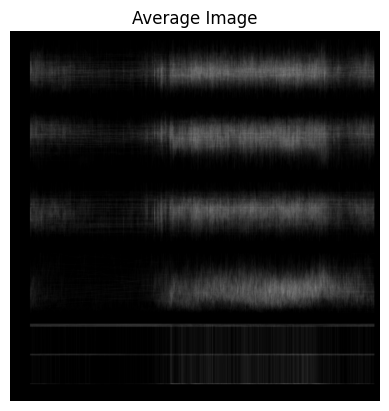

In [12]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 이미지 디렉터리 경로
image_dir = '../new_image_dataset'

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_dir) if f.endswith('test.png')]

# 첫 번째 이미지로 기준 크기 설정
first_image_path = os.path.join(image_dir, image_files[0])
first_image = Image.open(first_image_path)
image_size = first_image.size

# 이미지 불러오기 및 배열로 변환
images = []
for file in image_files:
    image_path = os.path.join(image_dir, file)
    image = Image.open(image_path).resize(image_size)
    images.append(np.array(image))

# 평균 이미지 계산
average_image = np.mean(images, axis=0).astype(np.uint8)

# 평균 이미지 시각화
plt.imshow(average_image)
plt.axis('off')
plt.title('Average Image')
plt.show()
